In [35]:
import os
import sys
sys.path.append('/home/yjzhu/scripts/SHARPESST')
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve_fft
import astropy.units as u

from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.coord_transform import coord_transform, trivialframe
from sharpesst.element_grid import detector_grid, source_grid
from sharpesst.coord_grid import coord_grid
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
from sharpesst.correct_2d_psf import correct_spice_raster, correct_spice_fits
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster

from juanfit import SpectrumFitRow, gaussian

In [12]:
NeVIII_cen = 770.428
dlambda = 0.0975
wvl = np.linspace(-10,10,21)*dlambda + NeVIII_cen
NeVIII_gaussian = gaussian(wvl, NeVIII_cen, 1, 0.25,)

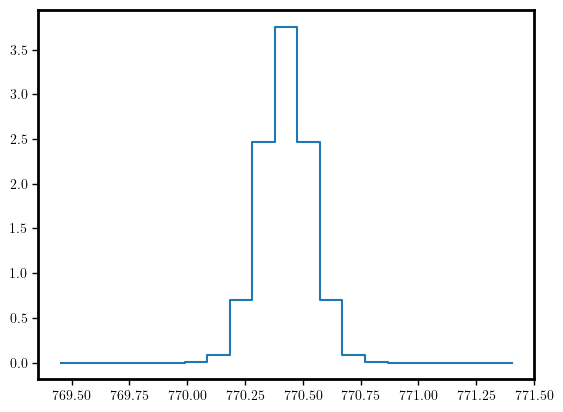

In [7]:
plt.step(wvl, NeVIII_gaussian, where='mid')

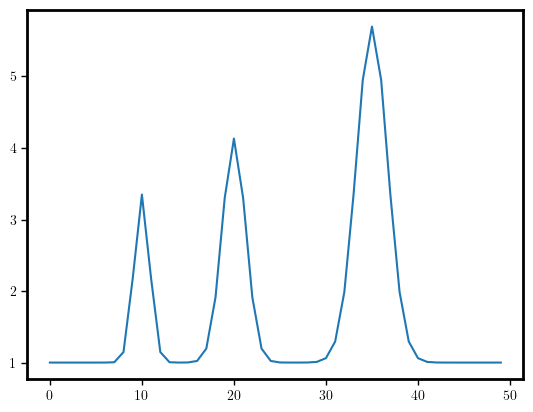

In [9]:
line_int_tot = np.ones(50)
peak_loc = np.array([10,20,35])
line_int_tot += gaussian(np.arange(50), peak_loc[0], 5, 2) + \
                gaussian(np.arange(50), peak_loc[1], 10, 3) + \
                gaussian(np.arange(50), peak_loc[2], 20, 4)

plt.plot(line_int_tot)

In [10]:
y_lambda_image = line_int_tot[:,np.newaxis]*NeVIII_gaussian[np.newaxis,:]

Text(0, 0.5, 'Y-Pix')

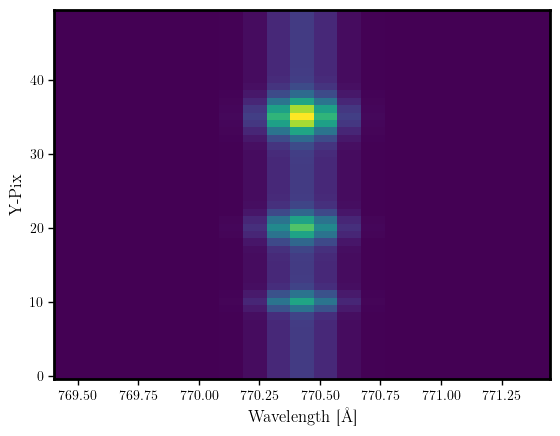

In [46]:
plt.imshow(y_lambda_image, aspect='auto', origin='lower', extent=[wvl[0]-dlambda/2, wvl[-1]+dlambda/2, -0.5, 49.5])
plt.xlabel(r'Wavelength [\AA]',fontsize=12)
plt.ylabel('Y-Pix',fontsize=12)

In [100]:
fake_psf = Gaussian2DKernel(x_stddev=4,y_stddev=3,theta=15*u.deg)

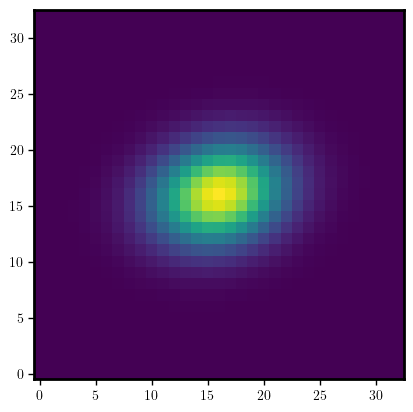

In [101]:
plt.imshow(fake_psf.array.value,origin="lower")

In [102]:
y_lambda_image_convolv = convolve_fft(y_lambda_image, fake_psf, boundary='wrap')

Text(0, 0.5, 'Y-Pix')

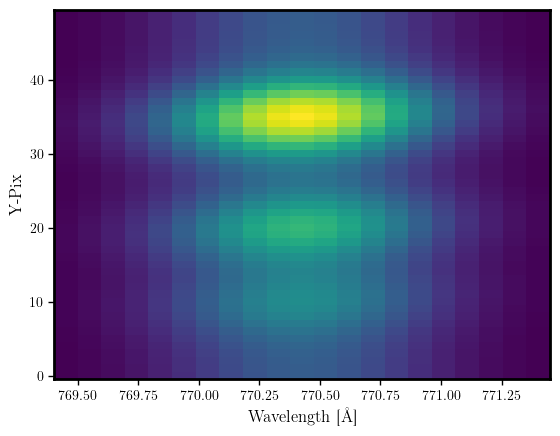

In [103]:
plt.imshow(y_lambda_image_convolv, aspect='auto', origin='lower', extent=[wvl[0]-dlambda/2, wvl[-1]+dlambda/2, -0.5, 49.5],)
plt.xlabel(r'Wavelength [\AA]',fontsize=12)
plt.ylabel('Y-Pix',fontsize=12)

In [104]:
fit_model = SpectrumFitRow(y_lambda_image_convolv, wvl, line_number=1,line_wvl_init=770.428,
                            int_max_init=1, fwhm_init=0.5)
fit_model.run_lse()

/home/yjzhu/scripts/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


In [105]:
fit_model.line_wvl_fit.shape

(50, 1)

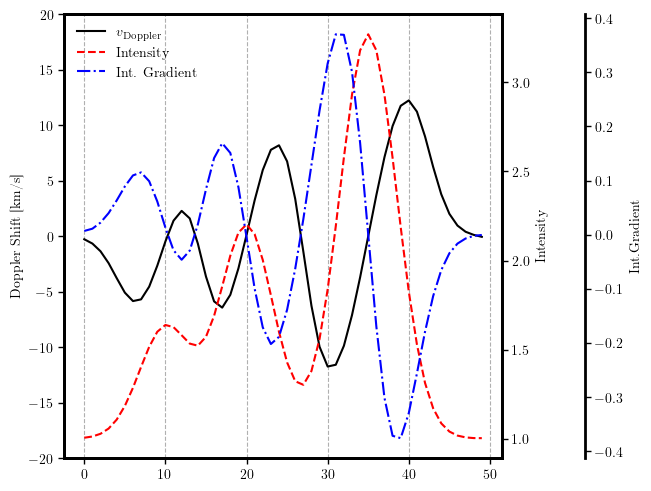

In [116]:
fig, ax_v = plt.subplots(constrained_layout=True)

ln1, = ax_v.plot(np.arange(50),(fit_model.line_wvl_fit[:,0]-NeVIII_cen)/NeVIII_cen*3e5, color='black', label=r"$v_{\rm Doppler}$")

ax_i = ax_v.twinx()

ln2, = ax_i.plot(np.arange(50),fit_model.int_total_fit[:,0], color='red', label="Intensity", ls='--')

ax_v.set_ylim(-20,20)


ax_i_grad = ax_v.twinx()
ln3, = ax_i_grad.plot(np.arange(50), np.gradient(fit_model.int_total_fit[:,0]), color='blue', label="Int. Gradient", ls='-.')
ax_i_grad.spines['right'].set_position(('outward', 60))

ax_i.tick_params(axis='y',right=True,labelright=True,left=False,labelleft=False)
ax_v.set_ylabel('Doppler Shift [km/s]')
ax_i.set_ylabel('Intensity')
ax_i_grad.set_ylabel('Int.Gradient')

ax_v.legend([ln1, ln2, ln3], [ln1.get_label(), ln2.get_label(), ln3.get_label()],frameon=False,loc='upper left')

ax_v.grid(axis='x',which='major',ls='--')

In [107]:
pxsz_mu, arcsperpx, angsperpx = 18, 1.1, 0.09 # microns per pixel, arcseconds per pixel. angstrom per pixel
platescale_x, platescale_y, platescale_l = pxsz_mu/np.array([arcsperpx,arcsperpx,angsperpx])

yl_core_xpo = 2.0
fwhm_core0_yl = np.array([2.0, 1.05])
gaussian_desc = 'Mod. Gaussian core: broad peak, narrow shoulder'+'; spatial average (lower half of slit)'

fwhm_wing0_yl = np.array([10.0, 2.0]) # Nominal values from Hardi
desc_str='; standard wing aspect ratio'
psf_yl_angle = -15*np.pi/180
wing_weight = 0.165

In [108]:
spice_file_path = '../../src/SPICE/20221024/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000.fits'
with fits.open(spice_file_path) as hdul:
    spice_data_0 = hdul[3].data.copy()
    spice_hdr = hdul[3].header.copy()

spice_dat1 = spice_data_0[0].transpose([2,1,0])

In [109]:
spice_hdr['CDELT3']

0.0097517

In [110]:
spice_dat1 = np.zeros((10,50,20))

In [111]:
amat_yl_core, amat_yl_wing, amat_yl_symm, amat_yl, metadict = get_fwd_matrices(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight, super_fac=1, psf_thold_core=0.0005)

Correcting Ne VIII 770 - Peak; ref. wavelength=767.6366184999999


Computing PSF Core:
4.904904904904905 % done after 0.05830264091491699 seconds
9.90990990990991 % done after 0.12643980979919434 seconds
14.914914914914915 % done after 0.18842744827270508 seconds
19.91991991991992 % done after 0.2522716522216797 seconds
24.924924924924923 % done after 0.34647679328918457 seconds
29.92992992992993 % done after 0.4020521640777588 seconds
34.93493493493494 % done after 0.47568774223327637 seconds
39.93993993993994 % done after 0.5566244125366211 seconds
44.94494494494494 % done after 0.6094119548797607 seconds
49.949949949949946 % done after 0.6637945175170898 seconds
54.95495495495496 % done after 0.7271299362182617 seconds
59.95995995995996 % done after 0.7903296947479248 seconds
64.96496496496496 % done after 0.8634927272796631 seconds
69.96996996996997 % done after 0.9198236465454102 seconds
74.97497497497497 % done after 0.9809341430664062 seconds
79.97997997997997 % done after 1.0374984741210938 seconds
84.98498498498499 % done after 1.088486909866

In [112]:
amat_yl_core.shape

(1000, 1000)